In [9]:
# To access GPU if available
!nvidia-smi

Sat Mar 16 03:36:14 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8              11W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
# Run this to access Google Drive for the data
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Installing YOLO environment

In [ ]:
!pip install ultralytics==8.0.196

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.196 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 28.9/78.2 GB disk)


# Downloading Data from Roboflow

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="api-key") 
project = rf.workspace("amirs-workspace").project("boards-0qnss")
dataset = project.version(4).download("yolov8")

# Model training
source: https://docs.ultralytics.com/modes/train/#multi-gpu-training

In [ ]:
# Train the model
!yolo task=detect mode=train model=yolov8n.pt data={dataset.location}/data.yaml epochs=200 batch=128 imgsz=640 plots=True project=/content/drive/MyDrive/GeorgiaTech/CDA_ISYE_6740/Project/models/batch_size_256

# Resuming training

In [ ]:
from ultralytics import YOLO

# Load a model
model = YOLO('/content/drive/MyDrive/GeorgiaTech/CDA_ISYE_6740/Project/models/train/weights/last.pt')  # load a partially trained model

# Resume training
results = model.train(resume=True)

# Testing the model on images


0: 640x640 1 good, 1 operator, 125.2ms
Speed: 4.8ms preprocess, 125.2ms inference, 9.5ms postprocess per image at shape (1, 3, 640, 640)


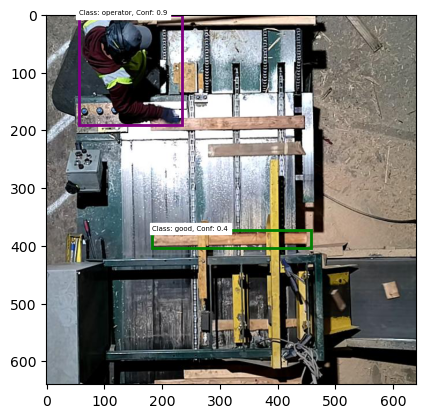


0: 640x640 2 goods, 1 operator, 137.7ms
Speed: 4.3ms preprocess, 137.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


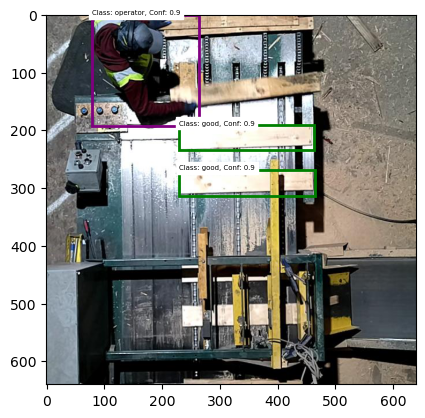

In [1]:
from ultralytics import YOLO
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
import numpy as np

# loading model
model = YOLO('models/batch_size_64/train/weights/best.pt')

im1 = plt.imread('data/test/images/video2_mp4-0027_jpg.rf.473d6efe10739caf49c656936664660a.jpg')

# picture directory
picdir = 'data/test/images/'
pics = [p for p in os.listdir('data/test/images/')]

# Driver Code for Visualization
for pic in pics[:2]:

  # reading in image
  im = plt.imread(picdir + pic)

  # making prediction on images
  results = model.predict(im)
  result = results[0]

  plt.imshow(im)

  for box in result.boxes:
    class_id = result.names[box.cls[0].item()]

    # assigning colors for each class
    if class_id == 'defective':
      col = 'red'
    if class_id == 'operator':
      col = 'purple'
    if class_id == 'good':
      col = 'green'

    cords = box.xyxy[0].tolist()
    cords = [round(x) for x in cords]
    conf = round(box.conf[0].item(), 2)
    rect = patches.Rectangle((cords[0], cords[1]), cords[2] - cords[0], cords[3] - cords[1], linewidth=2, edgecolor=col, facecolor='none')

    # Add the rectangle to the current axes
    plt.gca().add_patch(rect)

    # Display the class label and confidence score
    label = f'Class: {class_id}, Conf: {conf:.1f}'
    plt.text(cords[0], cords[1], label, color='black', backgroundcolor='white', fontsize=5)

  plt.show()

# Train Analysis

In [2]:
import pandas as pd

res4 = pd.read_csv('models/batch_size_4/results.csv')
res16 = pd.read_csv('models/batch_size_16/train/results.csv')
res64 = pd.read_csv('models/batch_size_64/train/results.csv')
res128 = pd.read_csv('models/batch_size_128/train/results.csv')
best = pd.read_csv('models/best/train/results.csv')

res = [res4, res16, res64, res128]

# removing whitespace from column names
for b in res:
    b.columns = b.columns.str.replace(' ', '') 

### Determing metrics of best model for each batch size

In [3]:
# source: https://stackoverflow.com/questions/75523057/how-is-the-yolov8-best-loss-model-selected-by-the-trainer-class

def fitness(x): 
     # Returns fitness (for use with results.txt or evolve.txt) 
     w = [0.0, 0.0, 0.1, 0.9]  # weights for [P, R, mAP@0.5, mAP@0.5:0.95] 
     return (x.iloc[:, 4:8] * w).sum(1) 

# dictionary of results
data = {'Batch Size': [], 'Epoch': [], 'Precision': [], 'Recall': [], 'mAP50': [], 'mAP50-95': [],
        'Val Loss': [], 'Fitness': []}

for i in range(len(res)):
    fit = fitness(res[i])
    
    if i == 0: bs = 4
    if i == 1: bs = 16
    if i == 2: bs = 64
    if i == 3: bs = 128
    
    data['Batch Size'].append(bs)
    data['Epoch'].append(fit.idxmax())
    data['Precision'].append(res[i]['metrics/precision(B)'][fit.idxmax()])
    data['Recall'].append(res[i]['metrics/recall(B)'][fit.idxmax()])
    data['mAP50'].append(res[i]['metrics/mAP50(B)'][fit.idxmax()])
    data['mAP50-95'].append(res[i]['metrics/mAP50-95(B)'][fit.idxmax()])
    data['Val Loss'].append(res[i]['val/cls_loss'][fit.idxmax()])
    data['Fitness'].append(max(fit))

pd.DataFrame(data)

,Batch Size,Epoch,Precision,Recall,mAP50,mAP50-95,Val Loss,Fitness
0,4,190,0.91142,0.98701,0.98139,0.88979,0.37285,0.898950
1,16,185,0.95936,0.98736,0.97898,0.90077,0.52398,0.908591
2,64,151,0.95210,0.98931,0.98012,0.88247,0.37694,0.892235
3,128,196,0.93496,0.98324,0.97565,0.88329,0.36440,0.892526


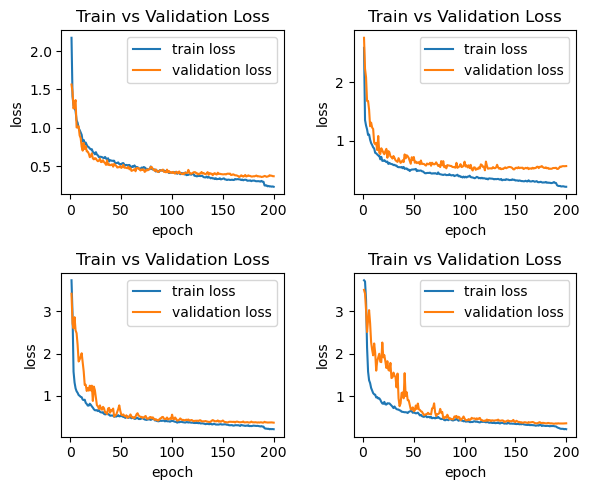

In [4]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(6, 5))

bs = [res4, res16, res64, res128]
for i in range(len(bs)):
    if i == 0: coords = (0, 0)
    if i == 1: coords = (0, 1)
    if i == 2: coords = (1, 0)
    if i == 3: coords = (1, 1)

    axes[coords].plot(bs[i]['epoch'], bs[i]['train/cls_loss'], label = 'train loss')
    axes[coords].plot(bs[i]['epoch'], bs[i]['val/cls_loss'], label = 'validation loss')
    axes[coords].set_xlabel('epoch')
    axes[coords].set_ylabel('loss')
    axes[coords].set_title('Train vs Validation Loss')
    axes[coords].legend()

plt.tight_layout()
plt.show()

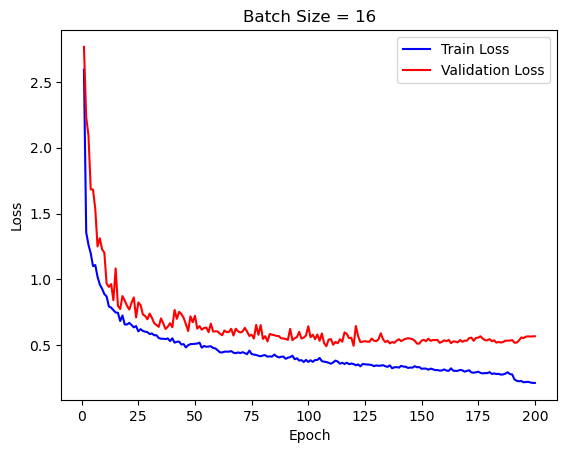

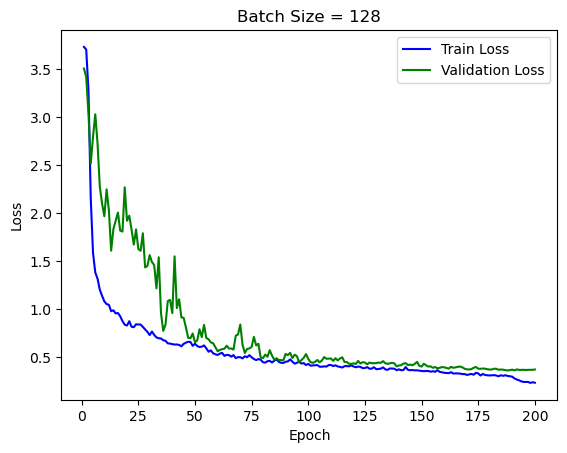

In [6]:
# batch size 16
plt.plot(res16['epoch'], res16['train/cls_loss'], label = 'Train Loss', color = 'blue')
plt.plot(res16['epoch'], res16['val/cls_loss'], label = 'Validation Loss', color = 'red')
plt.title('Batch Size = 16')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# batch size 64
plt.plot(res128['epoch'], res128['train/cls_loss'], label = 'Train Loss', color = 'blue')
plt.plot(res128['epoch'], res128['val/cls_loss'], label = 'Validation Loss', color = 'green')
plt.title('Batch Size = 128')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Testing on a Video
[Source](https://www.youtube.com/watch?v=Rwvd0PJF2jk)

In [ ]:
from ultralytics import YOLO

!yolo detect predict model='models/batch_size_128/train/weights/best.pt' source='videos/video2.mp4'